# Generating Player-Based Tables from LiveSum Data

## Part 0: Importing all necessary libraries

In [1]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt

## Part 1: Preprocessing the Data for use

### Part 1a. Loading Training and Test Data from the JSON Files

In [2]:
with open('train.json') as f:
    train_data = json.load(f)
train_df = pd.json_normalize(train_data)
with open('test.json') as f:
    test_data = json.load(f)
test_df = pd.json_normalize(test_data)

#display the first few rows of the dataframes
display(train_df.head())
display(test_df.head())

,text,table,id
0,And we're off for the start of the first half....,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513261
1,"And we're off, the First Half has kicked off. ...","Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513267
2,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513268
3,And we're underway in the first half. Player9(...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513270
4,The game is starting with the first half. Play...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513272


,text,table,id
0,And we're off for the first half. Player27(Awa...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513332
1,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25513360
2,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25600389
3,And we're off for the first half. Player26(Awa...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25617902
4,The game is underway with the start of the fir...,"Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,...",25892175


### Part 1b. Use the first Training Row to see if we can generate some player-based stats tables

In [3]:
train_row_1 = train_df.iloc[0]
train_comm = train_row_1['text']
print(train_comm)

And we're off for the start of the first half. Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half. Player8(Home Team) commits a foul. Player20(Away Team) earns a free kick on the right side of the field. Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece. The Away Team wins a corner kick. Player2(Home Team) earns a free kick on the right side of the field. Player24(Away Team) commits a foul. Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross. Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team. Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high. Player7(Home Team) commits a fo

In [4]:
#Making it a bit more readable
commentary = train_comm.replace('. ', '.\n')
print(commentary)


And we're off for the start of the first half.
Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half.
Player8(Home Team) commits a foul.
Player20(Away Team) earns a free kick on the right side of the field.
Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece.
The Away Team wins a corner kick.
Player2(Home Team) earns a free kick on the right side of the field.
Player24(Away Team) commits a foul.
Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross.
Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team.
Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high.
Player7(Home Team) commits a fo

### Part 1c. Attempt to extract the Players involved into two separate DataFrames

In [5]:
# Verify the content of the commentary variable
print(commentary)

# Adjust the regex pattern if necessary to match the actual format of the commentary
def extract_team_events(commentary, team_type):
    pattern = rf"Player\d+\s*\({team_type} Team\).*?"
    matches = re.findall(pattern, commentary)
    events = []
    for match in matches:
        player_match = re.search(r"Player\d+", match)
        if player_match:
            player = player_match.group()
            event = match.replace(player, "").strip()
            events.append({"Player": player, "Event": event})
    return pd.DataFrame(events)

# Recreate the DataFrames for home and away teams
home_team_df = extract_team_events(commentary, "Home")
away_team_df = extract_team_events(commentary, "Away")


And we're off for the start of the first half.
Player10(Home Team) commits a foul on Player23(Away Team), resulting in a free kick awarded in the defensive half.
Player8(Home Team) commits a foul.
Player20(Away Team) earns a free kick on the right side of the field.
Player26(Away Team) misses the header from the center of the box, it goes high and wide to the right, Player28(Away Team) assisted with a cross after a set piece.
The Away Team wins a corner kick.
Player2(Home Team) earns a free kick on the right side of the field.
Player24(Away Team) commits a foul.
Player6(Home Team) misses the goal with a shot from the center of the box, assisted by Player5(Home Team)'s cross.
Player24(Away Team) commits a foul, resulting in Player9(Home Team) being awarded a free kick in the attacking half, This leads to a set-piece opportunity for Player9(Home Team)'s team.
Player8(Home Team)'s attempt from outside the box on a direct free kick is just a little too high.
Player7(Home Team) commits a fo

In [6]:
display(home_team_df)

,Player,Event
0,Player10,(Home Team)
1,Player8,(Home Team)
2,Player2,(Home Team)
3,Player6,(Home Team)
4,Player5,(Home Team)
5,Player9,(Home Team)
6,Player9,(Home Team)
7,Player8,(Home Team)
8,Player7,(Home Team)
9,Player7,(Home Team)


In [7]:
display(away_team_df)

,Player,Event
0,Player23,(Away Team)
1,Player20,(Away Team)
2,Player26,(Away Team)
3,Player28,(Away Team)
4,Player24,(Away Team)
5,Player24,(Away Team)
6,Player23,(Away Team)
7,Player22,(Away Team)
8,Player24,(Away Team)
9,Player22,(Away Team)


### Part 1d. With the players extracted, now we try to add the stats (Shots, Fouls, Yellow Cards, Red Cards, FK, SOG, Shot Accuracy, etc.)

In [8]:
from collections import defaultdict
# Define all stat categories we expect
all_stats = [
    'Goals', 'Shots', 'Fouls', 'Yellow Cards', 'Red Cards',
    'Assists', 'Free Kicks', 'Offsides'
]
team_stat_keys = [
    'Goals', 'Shots', 'Fouls', 'Yellow Cards', 'Red Cards',
    'Free Kicks', 'Offsides', 'Corner Kicks'
]
# Define patterns for extracting player and team stats
patterns = {
    'Goals': r'(?P<player>Player\d+)\(.*?\).*?scores',
    'Shots': r'(?P<player>Player\d+)\(.*?\).*?shot',
    'Fouls': r'(?P<player>Player\d+)\(.*?\).*?foul',
    'Yellow Cards': r'(?P<player>Player\d+)\(.*?\).*?yellow card',
    'Red Cards': r'(?P<player>Player\d+)\(.*?\).*?red card',
    'Assists': r'assisted by (?P<player>Player\d+)',
    'Free Kicks': r'(?P<player>Player\d+)\(.*?\).*?free kick',
    'Offsides': r'(?P<player>Player\d+)\(.*?\).*?offside',
    'Corners': r'The (Home|Away) Team wins a corner kick'
}

# Initialize dictionaries to store player and team stats
player_stats = defaultdict(lambda: defaultdict(int))
team_stats = defaultdict(lambda: defaultdict(int))

# Extract stats from the commentary
for stat, pattern in patterns.items():
    matches = re.finditer(pattern, commentary)
    for match in matches:
        if stat == 'Corners':
            team = match.group(1) + " Team"
            team_stats[team]['Corner Kicks'] += 1
        else:
            player = match.group('player')
            player_stats[player][stat] += 1
            team = 'Home Team' if 'Home Team' in match.group(0) else 'Away Team'
            if stat in ['Goals', 'Shots', 'Fouls', 'Yellow Cards', 'Red Cards', 'Free Kicks', 'Offsides']:
                team_stats[team][stat] += 1


# Create player stats DataFrame with all expected columns
player_stats_df = pd.DataFrame([
    {'Player': player, **{stat: stats.get(stat, 0) for stat in all_stats}}
    for player, stats in player_stats.items()
])

# Optional: Ensure consistent column order
player_stats_df = player_stats_df[['Player'] + all_stats]

# Split players by team
home_team_players = home_team_df['Player'].unique()
away_team_players = away_team_df['Player'].unique()

home_players_df = player_stats_df[player_stats_df['Player'].isin(home_team_players)]
away_players_df = player_stats_df[player_stats_df['Player'].isin(away_team_players)]

# Create team stats DataFrame with all expected columns
team_stats_df = pd.DataFrame([
    {'Team': team, **{stat: stats.get(stat, 0) for stat in team_stat_keys}}
    for team, stats in team_stats.items()
])

# Optional: Ensure consistent column order
team_stats_df = team_stats_df[['Team'] + team_stat_keys]

# Display the player and team stats
display(home_players_df)
display(away_players_df)
display(team_stats_df)

,Player,Goals,Shots,Fouls,Yellow Cards,Red Cards,Assists,Free Kicks,Offsides
1,Player6,1,5,1,0,0,1,1,0
2,Player7,0,1,2,1,0,0,0,0
3,Player10,0,3,3,0,0,1,3,0
7,Player8,0,0,3,0,0,1,2,0
11,Player14,0,0,2,0,0,0,2,0
12,Player5,0,0,1,0,0,1,0,0
13,Player11,0,0,1,1,0,0,2,0
14,Player3,0,0,1,0,0,0,1,0
16,Player2,0,0,0,0,0,0,2,0
18,Player4,0,0,0,0,0,0,1,0


,Player,Goals,Shots,Fouls,Yellow Cards,Red Cards,Assists,Free Kicks,Offsides
0,Player26,1,3,2,0,0,0,1,1
4,Player25,0,1,2,2,0,0,0,0
5,Player27,0,1,1,0,0,0,1,0
6,Player29,0,1,0,0,0,1,0,0
8,Player24,0,0,2,0,0,0,1,0
9,Player22,0,0,1,0,0,0,0,0
10,Player28,0,0,1,1,0,0,0,0
15,Player20,0,0,0,0,0,0,2,0
17,Player23,0,0,0,0,0,0,1,0
19,Player35,0,0,0,0,0,0,1,0


,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Free Kicks,Offsides,Corner Kicks
0,Away Team,1,6,9,3,0,6,1,2
1,Home Team,1,9,14,2,0,16,0,4


### Part 1e. Extract the 'tables' from the row to find out what the stats should be

In [9]:
# Extract the table string from the first row of train_df
table_string = train_df.iloc[0]['table']

# Split the table string into rows
table_rows = table_string.split('<NEWLINE>')

# Extract the header and data rows
header = table_rows[0].split(',')
data = [row.split(',') for row in table_rows[1:]]

# Create a pandas DataFrame
table_df = pd.DataFrame(data, columns=header)


# Display the DataFrame
display(table_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Corner Kicks,Free Kicks,Offsides
0,Away Team,1,8,10,3,0,4,12,1
1,Home Team,1,13,12,2,0,9,10,0


### Part 1f. Display the two Player-wise Statistics Tables to show the data collected

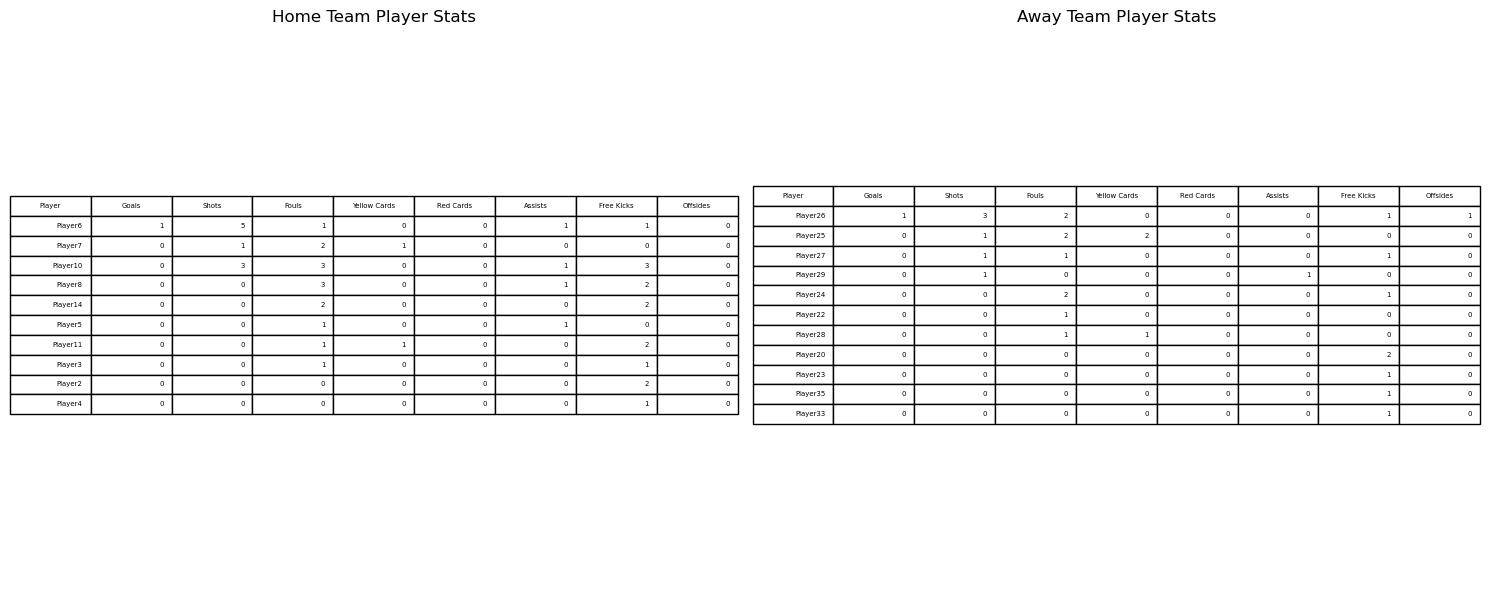

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot home team stats
axes[0].axis('tight')
axes[0].axis('off')
axes[0].table(cellText=home_players_df.values, colLabels=home_players_df.columns, loc='center')
axes[0].set_title('Home Team Player Stats')

# Plot away team stats
axes[1].axis('tight')
axes[1].axis('off')
axes[1].table(cellText=away_players_df.values, colLabels=away_players_df.columns, loc='center')
axes[1].set_title('Away Team Player Stats')

plt.tight_layout()
plt.show()

In [11]:
# Display the team-wise stats table
display(team_stats_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Free Kicks,Offsides,Corner Kicks
0,Away Team,1,6,9,3,0,6,1,2
1,Home Team,1,9,14,2,0,16,0,4


In [12]:
# Reorder the columns in team_stats_df to match the order in table_df
team_stats_df = team_stats_df[table_df.columns]

# Display the updated DataFrame
display(team_stats_df)

,Team,Goals,Shots,Fouls,Yellow Cards,Red Cards,Corner Kicks,Free Kicks,Offsides
0,Away Team,1,6,9,3,0,2,6,1
1,Home Team,1,9,14,2,0,4,16,0


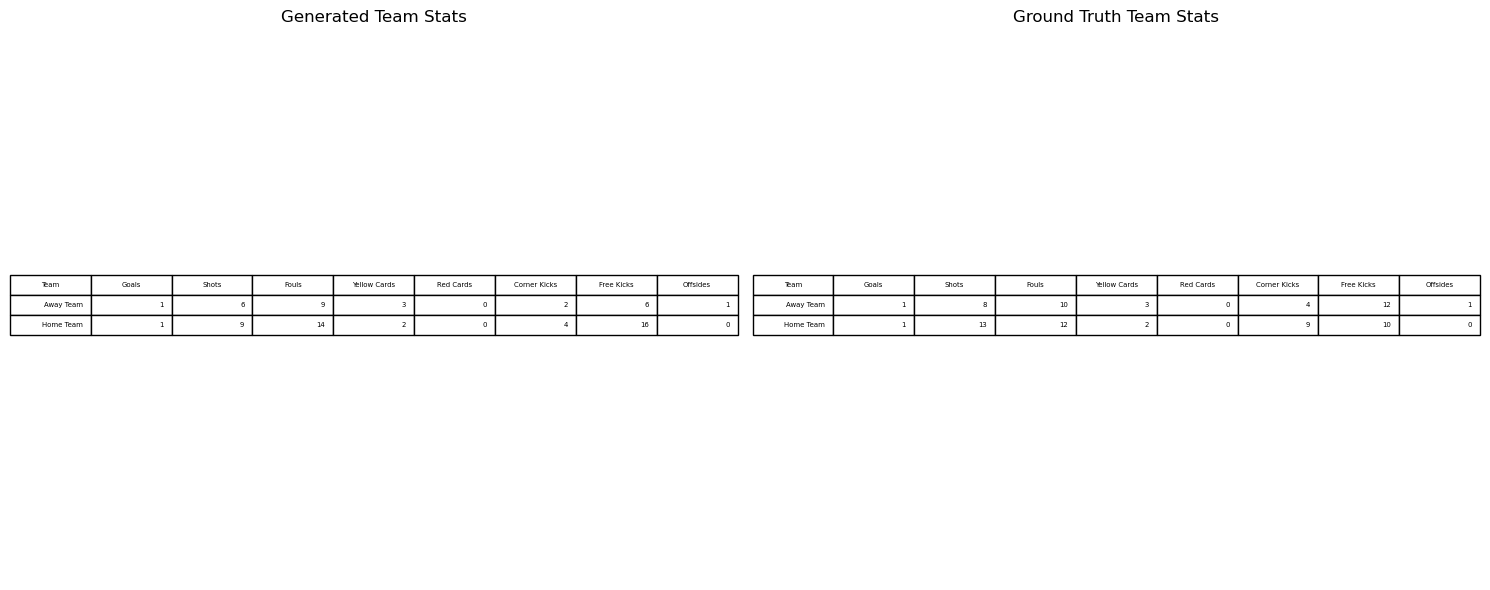

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the generated/calculated team stats table
axes[0].axis('tight')
axes[0].axis('off')
axes[0].table(cellText=team_stats_df.values, colLabels=team_stats_df.columns, loc='center')
axes[0].set_title('Generated Team Stats')

# Plot the table from the data
axes[1].axis('tight')
axes[1].axis('off')
axes[1].table(cellText=table_df.values, colLabels=table_df.columns, loc='center')
axes[1].set_title('Ground Truth Team Stats')

plt.tight_layout()
plt.show()